## Inicialización

<div class="alert alert-block alert-success">
<b>Review General. (Iteración 1) </b> <a class="tocSkip"></a>

Tania, siempre me tomo este tiempo al inicio del proyecto para comentar mis apreciaciones generales de esta primera iteración de la entrega. 
    
En primera instancia disculpas por la demora, debido a la gran cantidad de proyectos de alto nivel y la poca disponibilidad de revisores para estos casos se han apilado los proyectos.    

Siempre me gusta comenzar dando la bienvenida al mundo de los datos a los estudiantes, te deseo lo mejor y espero que consigas lograr tus objetivos. Personalmente siempre me gusta brindar el siguiente consejo, "Está bien equivocarse, es normal y es lo mejor que te puede pasar. Aprendemos de los errores y eso te hará mejor programando ya que podrás descubrir cosas a medida que avances y son estas cosas las que te darán esa experiencia para ser mejor como Data Scientist"
    
Ahora si yendo a esta notebook. Tania, lo he dicho al final del proyecto pero lo resalto aquí nuevamente, tu proyecto está muy bien resuelto, resalta capacidad y comprensión de todas las herrramientas, como a la vez esta ordenado y es sencillo de seguir, felictiaciones!

Este proyecto está en condiciones de ser aprobado! Éxitos dentro de tu camino en el mundo de los datos!

Saludos Tania!

## Cargar datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/`
- La carpeta `final_files` con 7600 fotos
- El archivo `labels.csv` con leyendas, con dos columnas: `file_name` y `real_age`

Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img

labels_path = '/datasets/faces/labels.csv'
images_path = '/datasets/faces/final_files/'
labels = pd.read_csv(labels_path)

## EDA

In [2]:
# Tamaño de conjunto de datos
print("Número total de imágenes:", labels.shape[0])

# info
labels.info()

Número total de imágenes: 7591
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


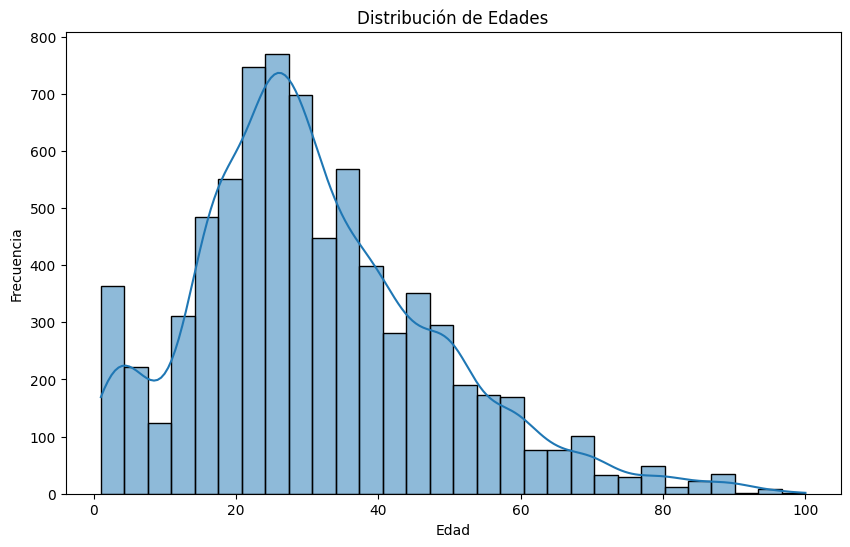

In [5]:
# distribucion de edades

plt.figure(figsize=(10, 6))
sns.histplot(labels['real_age'], bins=30, kde=True)
plt.title("Distribución de Edades")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.show()

<div class="alert alert-block alert-success">
<b>Comentario del revisor. (Iteración 1)</b> <a class="tocSkip"></a>

Impresionante! Muy bien visualizadas las distribuciones de las edades de las personas en nuestras imagenes, bien hecho Tania!

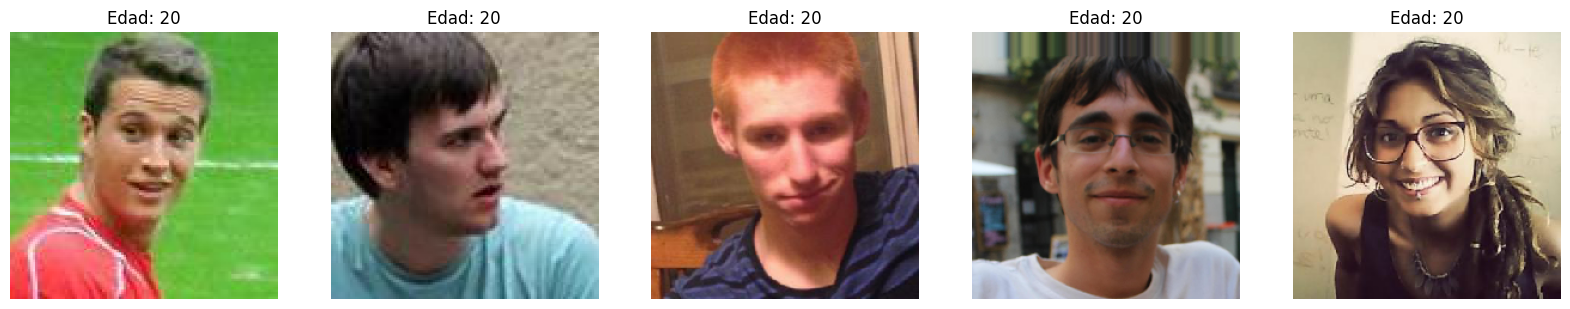

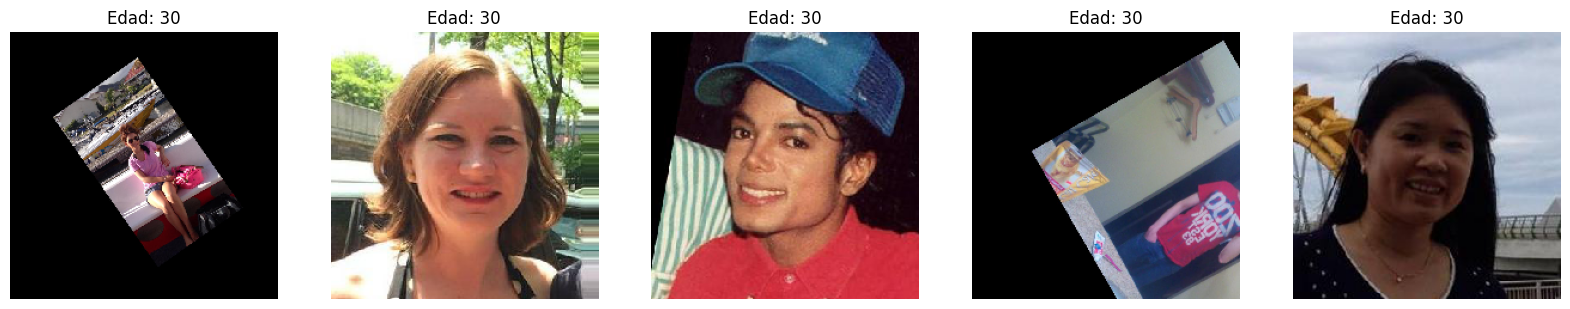

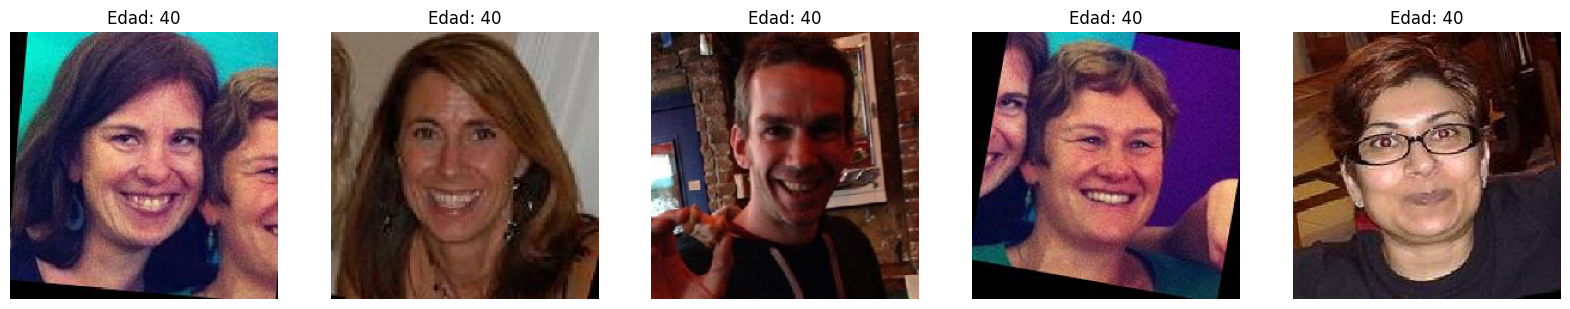

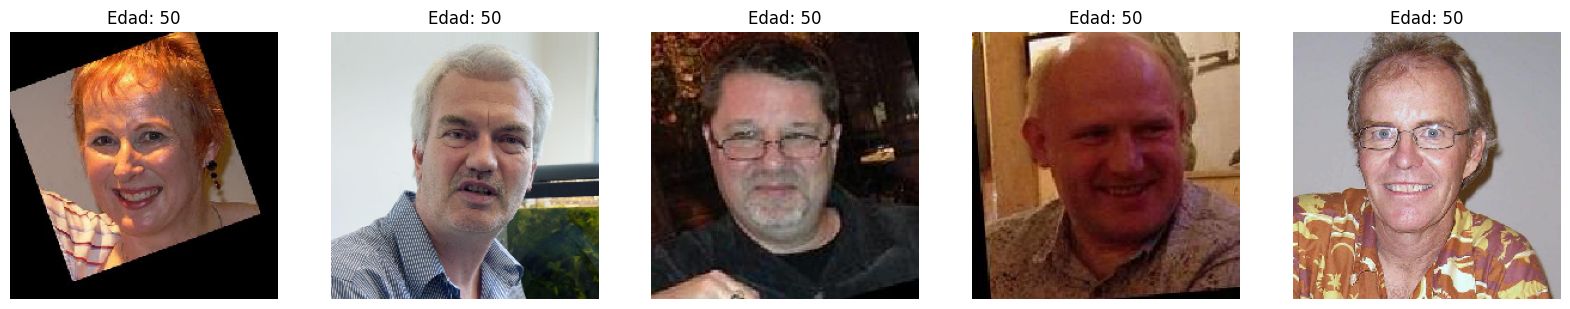

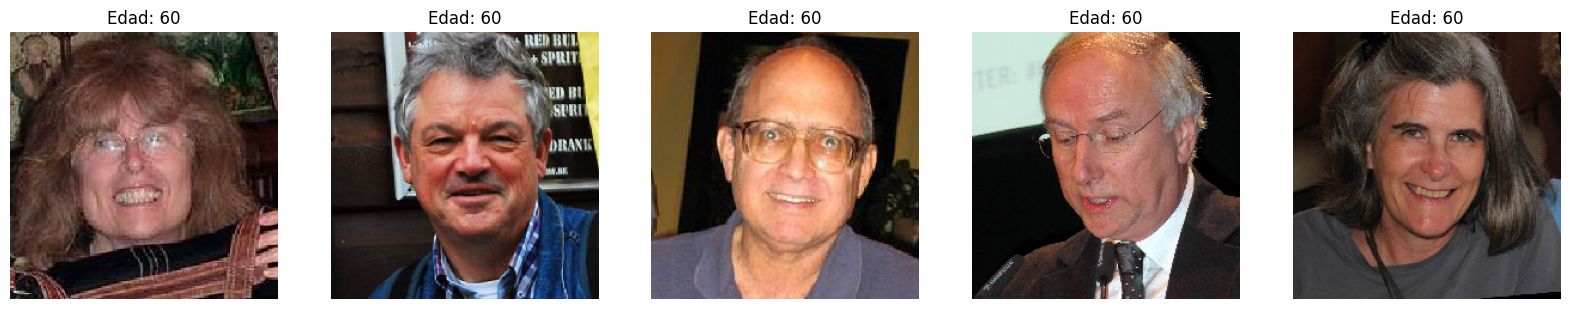

In [6]:
# Imprimir fotos para diferentes edades
def show_images_for_age(age, num_images=5):
    age_images = labels[labels['real_age']
                        == age]['file_name'].head(num_images)
    plt.figure(figsize=(20, 10))
    for i, file_name in enumerate(age_images):
        img = load_img(images_path + file_name, target_size=(224, 224))
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"Edad: {age}")
        plt.axis('off')
    plt.show()


# Mostrar algunas imágenes para diferentes edades
for age in range(20, 61, 10):
    show_images_for_age(age)

<div class="alert alert-block alert-success">
<b>Comentario del revisor. (Iteración 1)</b> <a class="tocSkip"></a>

Excelente visualización de las imagenes con las que trabajaremos, sigamos!

### Conclusiones

Podemos ver que no hay datos faltantes en el archivo de labels. En cuanto a la distribución de las edades, éstas oscilan entre los 20 y 40 años en su mayoría y al momento de seleccionar fotografias con diferentes rangos de edad, se puede apreciar visualmente las diferencias entre los grupos, llegando a la conclusión de que la información se encuentra bien estructurada para poder proseder con los siguientes pasos de la creacion del algoritmo. 

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crear un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [ ]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

In [ ]:
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

<div class="alert alert-block alert-success">
<b>Comentario del revisor. (Iteración 1)</b> <a class="tocSkip"></a>

Muy buen armadas las funciones, aquí podríamos probar diferentes valores del lote para observar si hay mejoras de eficiencia en los modelos, pero por otro lado excelente al mantenter los tamaños de entrada iguales. Sigamos!

In [ ]:
def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

<div class="alert alert-block alert-success">
<b>Comentario del revisor. (Iteración 1)</b> <a class="tocSkip"></a>

Excelente creación de modelo Tania, en primera instancia implementando el modelo sugerido Resnet50, y luego creando la estructura del modelo aplicando tanto capas como el optimizador y compilando. Una forma de visualizar mejoras en los modelos es probando diferentes tasas de aprendizaje o la agregación de mayor cantidad de capas.

In [ ]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

<div class="alert alert-block alert-success">
<b>Comentario del revisor. (Iteración 1)</b> <a class="tocSkip"></a>

Un armado perfecto Tania, bien hecho! Aquí podríamos agregar al inicio la línea **%%time** para obser el tiempo que demora esta ejecución.

### Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [ ]:
# prepara un script para ejecutarlo en la plataforma GPU

import inspect
init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""


with open('run_model_on_gpu.py', 'w') as f:

    f.write(init_str)
    f.write('\n\n')

    for fn_name in [load_train, load_test, create_model, train_model]:

        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Resultado

Coloca aquí el resultado de la plataforma GPU como una celda Markdown.



    8192/94765736 [..............................] - ETA: 1s
 9273344/94765736 [=>............................] - ETA: 0s
19079168/94765736 [=====>........................] - ETA: 0s
28459008/94765736 [========>.....................] - ETA: 0s
37969920/94765736 [===========>..................] - ETA: 0s
47341568/94765736 [=============>................] - ETA: 0s
56565760/94765736 [================>.............] - ETA: 0s
66224128/94765736 [===================>..........] - ETA: 0s
75677696/94765736 [======================>.......] - ETA: 0s
85000192/94765736 [=========================>....] - ETA: 0s
94773248/94765736 [==============================] - 1s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 356 steps, validate for 119 steps
Epoch 1/20
2024-06-08 21:24:13.821942: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-06-08 21:24:14.539010: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 60s - loss: 216.0993 - mae: 11.1065 - val_loss: 359.7147 - val_mae: 14.1088
Epoch 2/20
356/356 - 40s - loss: 134.5833 - mae: 8.8922 - val_loss: 225.4561 - val_mae: 11.7226
Epoch 3/20
356/356 - 39s - loss: 106.0420 - mae: 7.9003 - val_loss: 179.1009 - val_mae: 10.0706
Epoch 4/20
356/356 - 40s - loss: 96.1105 - mae: 7.4767 - val_loss: 119.4943 - val_mae: 8.2787
Epoch 5/20
356/356 - 39s - loss: 78.1027 - mae: 6.7128 - val_loss: 168.1214 - val_mae: 10.1353
Epoch 6/20
356/356 - 40s - loss: 67.9777 - mae: 6.3238 - val_loss: 195.0444 - val_mae: 11.0451
Epoch 7/20
356/356 - 40s - loss: 60.9603 - mae: 6.0316 - val_loss: 130.8090 - val_mae: 8.5224
Epoch 8/20
356/356 - 39s - loss: 53.3624 - mae: 5.5758 - val_loss: 123.5580 - val_mae: 8.4729
Epoch 9/20
356/356 - 39s - loss: 46.4984 - mae: 5.2370 - val_loss: 102.7407 - val_mae: 7.5974
Epoch 10/20
356/356 - 39s - loss: 36.7241 - mae: 4.6792 - val_loss: 115.5534 - val_mae: 7.9268
Epoch 11/20
356/356 - 39s - loss: 33.0584 - mae: 4.4152 - val_loss: 125.3542 - val_mae: 8.0355
Epoch 12/20
356/356 - 40s - loss: 29.8328 - mae: 4.2055 - val_loss: 95.1260 - val_mae: 7.2380
Epoch 13/20
356/356 - 39s - loss: 25.7465 - mae: 3.9296 - val_loss: 112.7822 - val_mae: 8.1733
Epoch 14/20
356/356 - 39s - loss: 22.9285 - mae: 3.6671 - val_loss: 104.9905 - val_mae: 7.7388
Epoch 15/20
356/356 - 40s - loss: 20.3679 - mae: 3.4786 - val_loss: 101.5631 - val_mae: 7.5078
Epoch 16/20
356/356 - 40s - loss: 21.7827 - mae: 3.5803 - val_loss: 88.0375 - val_mae: 6.9317
Epoch 17/20
356/356 - 39s - loss: 25.4243 - mae: 3.8532 - val_loss: 92.9443 - val_mae: 7.1476
Epoch 18/20
356/356 - 40s - loss: 20.6812 - mae: 3.5200 - val_loss: 92.0991 - val_mae: 7.3079
Epoch 19/20
356/356 - 40s - loss: 18.5931 - mae: 3.2862 - val_loss: 88.8232 - val_mae: 7.0701
Epoch 20/20
356/356 - 39s - loss: 16.3119 - mae: 3.1023 - val_loss: 77.0140 - val_mae: 6.5485
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 77.0140 - mae: 6.5485
Test MAE: 6.5485

<div class="alert alert-block alert-success">
<b>Comentario del revisor. (Iteración 1)</b> <a class="tocSkip"></a>

Muy bien hecho Tania, hemos podido correr el modelo y hemos obtenido muy buenos resultados, felicitaciones!

## Conclusiones

El proyecto muestra que los modelos de aprendizaje pueden ser muy utiles para predecir la edad a partir de imagenes, ya que obtuvimos un MAE de 6.5 años, pero también destaca la necesidad de mejoras contínuas y validación rigurosa para acciones críticas tal como la determinación de la edad para la venta de alcohol pues este error medio es grande para ello. Una recomendación sería combinar esta herramienta con otros medios de identificación de edad como identificaciones para el cumplimiento legal. 

 Otro enfoque que podría ser efectivo es entrenar el modelo específicamente con imágenes de personas cuyas edades están entre los 15 y 30 años. Las características faciales en este rango de edad son esenciales para la determinación legal de la venta de alcohol. 

<div class="alert alert-block alert-success">
<b>Comentario del revisocr. (Iteración 1)</b> <a class="tocSkip"></a>

Excelente conclusión Tania, destaco el rendimiento exitoso del modelo y sobre todo el procedimiento aplicado. El modelo cumple con los criterios establecidos y tus conclusiones demuestran tu comprensión de lo aplicado y obtenido. Felicitaciones!